## 模型訓練階段

In [1]:
#-----------引入基本套件-----------#
import time
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from keras import backend as K
from keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,
                             TensorBoard)
from keras.metrics import categorical_accuracy
from keras.optimizers import Adam
from keras.utils.data_utils import get_file
from PIL import Image   
#-----------引入模型架構-----------#
from nets.generator_training import *  #引入.fir_generator所需要使用的生成器
from nets.unet import *                         #從net/unet.py 中引入Unet模型，內有Unet3、4、5、6
from nets.FCN8 import *                       #FCN8
from nets.pspnet import pspnet           #PSPNET
#-----引入損失函數&評價函數-----#
from utils.loss import *       #調用自訂義的損失函數
from utils.metrics import *  #調用自訂義的評價函數

Using TensorFlow backend.
C:\Users\Jwander\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Jwander\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Jwander\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Jwand

## 全域變數
使用這裡的變數來調整參數，以下做小規模測試方便理解

In [2]:
#---------控制輸入圖片---------#
RA = True  #True則代表輸入該圖片
RD = True
IR = True
GI = False
#---------控制雨量區間---------#
interval = 'EWB01' #EWB01共100個標籤
num_classes = 100
#---------控制移動時間--------#
shift = 1                        #預測 t+shift 時刻
t2t = 't2t+'+str(shift)
#--------控制訓練的參數------#
Freeze_Epoch = 100            #訓練輪次
Batch_size = 8                   #批次大小
focal_loss = False              #控制是否使用focal loss，False則 = 'categorical_crossentropy'
choose_model = 'Unet3'   #模型名稱

## 訓練模型
計算完的權重會儲存至checkpoint資料夾中

In [3]:
time_start = time.time()  #計時器
if __name__ == "__main__":   
    K.clear_session()  #清空權重
    log_dir = "logs/"
    #   輸入圖片的通道數，根據不同參數有不同通道數or圖片大小
    if RD==True and IR==False and RA==False:   #RD
        inputs_size = [128,128,3]
    elif RD==False and IR==False and RA==True:   #RA
        inputs_size = [128,128,3]
    elif RD==False and IR==True and RA==False:  #IR
        inputs_size = [128,128,3]
    elif RD==True and IR==True and RA==False:  #RD+IR
        inputs_size = [128,128,4]
    elif RD==True and IR==False and RA==True:  #RD+RA
        inputs_size = [128,128,6]
    elif RD==False and IR==True and RA==True:  #IR+RA
        inputs_size = [128,128,4]
    elif RD==True and IR==True and RA==True:  #RD+IR+RA
        inputs_size = [128,128,7]
        
    if GI == True:
        inputs_size[2] = inputs_size[2] +2  #channel+2，GI加在最後一層

    # 選擇要用的model
    if choose_model == 'Unet6':
        model = Unet6(inputs_size,num_classes)
    elif choose_model == 'Unet5':
        model = Unet5(inputs_size,num_classes)
    elif choose_model == 'Unet4':
        model = Unet4(inputs_size,num_classes)
    elif choose_model == 'Unet3':
        model = Unet3(inputs_size,num_classes)
    elif choose_model == 'FCN8':
        model = FCN8(inputs_size,num_classes)
    elif choose_model == 'pspnet':
        model = pspnet(inputs_size,num_classes)
    #-------------------------------------------#
    # 打開數據集的訓練.txt  
    with open(r"database/train_list/"+t2t+"/train.txt","r") as f:
        train_lines = f.readlines()
    # 打開數據集的驗證.txt 
    with open(r"database/train_list/"+t2t+"/val.txt","r") as f:
        val_lines = f.readlines()
    #-------------------------------------------------------------------------------#
    #   訓練參數的設置
    #   logging表示tensorboard的保存位址
    #   checkpoint用於設置權值保存的細節，period用於修改多少epoch保存一次
    #   reduce_lr用於設置學習率下降的方式
    #   early_stopping用於設置早停，val_loss多次不下降自動結束訓練，表示模型基本收斂
    #-------------------------------------------------------------------------------#
    checkpoint_period = ModelCheckpoint('checkpoint/'+choose_model+'_val_min_RMSE.h5',
                                    monitor='val__RMSE', save_weights_only=True, save_best_only=True, verbose=1, period=1,
                                       mode='min') #若更換評價指標須注意模式的問題
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1,mode='min')
    #factor 降低學習率的因數 lr = lr * factor 
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1,mode='min',restore_best_weights=True)
    #monitor 監測的數據對像；patience 10輪沒有進步訓練便停止；restore_best_weight=True讓最後輸出的模型是回復到前10輪最佳的那個模型
    tensorboard = TensorBoard(log_dir=log_dir)
    #------------------------------------------------------#
    #   提示OOM或者顯存不足請調小Batch_size
    #------------------------------------------------------#
    alpha = []
    for i in range(num_classes-len(alpha)):  #循環加入標籤權重，從1~num_class
        alpha.append([i+1])
    #alpha為focal loss 1所使用之函數，各類別的加權
    if True:
        lr = 1e-4
        Init_Epoch = 0
        #Freeze_Epoch = 100
        #Batch_size = 16
        #判斷是否要使用focal loss，若不用則使用交叉熵'categorical_crossentropy'
        model.compile(loss =multi_category_focal_loss1(alpha=alpha,gamma=2.0) if focal_loss else 'categorical_crossentropy',
                optimizer = Adam(lr=lr),
                metrics = [Iou_score(),f_score(), precision(),recall(),'acc',mean_RMSE(),blank_RMSE()])
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(len(train_lines), len(val_lines), Batch_size))
        
        gen = Generator_merge(Batch_size, train_lines, inputs_size, num_classes,RD=RD,IR=IR,GI=GI,RA=RA,interval=interval).generate()  #訓練集
        gen_val = Generator_merge_val(1, val_lines, inputs_size, num_classes,RD=RD,IR=IR,GI=GI,RA=RA,interval=interval).generate() #驗證集 
        #gen_val 批次=1是為了計算驗證時能計算到所有的資料(使用batch size=1遍歷整個驗證集)
        history = model.fit_generator(gen,
                steps_per_epoch=max(1, len(train_lines)//Batch_size),
                validation_data=gen_val,
                validation_steps= len(val_lines),  #驗證步伐=1所以驗證步數要=len(val) 資料長度
                epochs=Freeze_Epoch,
                initial_epoch=Init_Epoch,
                callbacks=[checkpoint_period,tensorboard,early_stopping])
        #model.save_weights('model_data/unet_weights_rain.h5')  #保存最後一個模型權重
        #model.save('model_data/unet_full_rain.h5')  #保存最後一個模型
time_end = time.time()
time_c= time_end - time_start   #執行所花時間
print('time cost', time_c, 's')








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Train on 173 samples, val on 55 samples, with batch size 8.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
21/21 [==============================] - 6s 300ms/step - loss: 2.8147 - _Iou_score: 0.1068 - _f_score: 0.1076 - metric_precision: 0.1410 - metric_recall: 0.7495 - acc: 0.7610 - _RMSE: 17.5427 - _blank: 5.3572 - val_loss: 2.4038 - val__Iou_score: 0.3377 - val__f_score: 0.3385 - val_metric_precision: 0.4938 - val_metric_recall: 0.6189 - val_acc: 0.8499 - val__RMSE: 8.4782 - val__blank: 8.4782

Epoch 00001: val__RMSE improved from inf to 8.47822, saving model to checkpoint/Unet3_val_min_RMSE.h5
Epoch 2/100
21/21 [==============================] - 3s 158ms/step - loss: 1.5118 - _Iou_score: 0.3298 - _f_score: 0.3306 - metric_precision: 0.4103 - metric_recall: 0.7488 - acc: 0.8914 - _RMSE: 5.4620 - _blank:

21/21 [==============================] - 3s 155ms/step - loss: 0.4013 - _Iou_score: 0.4788 - _f_score: 0.4815 - metric_precision: 0.4978 - metric_recall: 0.7678 - acc: 0.8946 - _RMSE: 5.1409 - _blank: 5.1922 - val_loss: 0.5666 - val__Iou_score: 0.2980 - val__f_score: 0.3021 - val_metric_precision: 0.3240 - val_metric_recall: 0.6263 - val_acc: 0.8501 - val__RMSE: 8.3926 - val__blank: 8.4782

Epoch 00012: val__RMSE improved from 8.44718 to 8.39259, saving model to checkpoint/Unet3_val_min_RMSE.h5
Epoch 13/100
21/21 [==============================] - 3s 156ms/step - loss: 0.3860 - _Iou_score: 0.4835 - _f_score: 0.4864 - metric_precision: 0.5056 - metric_recall: 0.7638 - acc: 0.8991 - _RMSE: 5.0634 - _blank: 5.1973 - val_loss: 0.5699 - val__Iou_score: 0.3104 - val__f_score: 0.3146 - val_metric_precision: 0.3385 - val_metric_recall: 0.6261 - val_acc: 0.8520 - val__RMSE: 8.1989 - val__blank: 8.4782

Epoch 00013: val__RMSE improved from 8.39259 to 8.19893, saving model to checkpoint/Unet3_val


Epoch 00028: val__RMSE did not improve from 5.11407
Epoch 29/100
21/21 [==============================] - 3s 155ms/step - loss: 0.3658 - _Iou_score: 0.5781 - _f_score: 0.5822 - metric_precision: 0.6074 - metric_recall: 0.7572 - acc: 0.8951 - _RMSE: 3.5352 - _blank: 5.4280 - val_loss: 0.5086 - val__Iou_score: 0.4494 - val__f_score: 0.4549 - val_metric_precision: 0.4853 - val_metric_recall: 0.6297 - val_acc: 0.8555 - val__RMSE: 5.2785 - val__blank: 8.4782

Epoch 00029: val__RMSE did not improve from 5.11407
Epoch 30/100
21/21 [==============================] - 3s 156ms/step - loss: 0.3547 - _Iou_score: 0.5973 - _f_score: 0.6014 - metric_precision: 0.6234 - metric_recall: 0.7612 - acc: 0.8976 - _RMSE: 3.3836 - _blank: 5.4286 - val_loss: 0.5099 - val__Iou_score: 0.4810 - val__f_score: 0.4866 - val_metric_precision: 0.5254 - val_metric_recall: 0.6295 - val_acc: 0.8562 - val__RMSE: 5.4116 - val__blank: 8.4782

Epoch 00030: val__RMSE did not improve from 5.11407
Epoch 31/100
21/21 [=========


Epoch 00046: val__RMSE did not improve from 4.87681
Epoch 47/100
21/21 [==============================] - 3s 151ms/step - loss: 0.3238 - _Iou_score: 0.6467 - _f_score: 0.6511 - metric_precision: 0.6726 - metric_recall: 0.7715 - acc: 0.9025 - _RMSE: 3.0404 - _blank: 5.1165 - val_loss: 0.5102 - val__Iou_score: 0.5076 - val__f_score: 0.5136 - val_metric_precision: 0.5472 - val_metric_recall: 0.6313 - val_acc: 0.8536 - val__RMSE: 4.9754 - val__blank: 8.4782

Epoch 00047: val__RMSE did not improve from 4.87681
Epoch 48/100
21/21 [==============================] - 3s 150ms/step - loss: 0.3232 - _Iou_score: 0.6452 - _f_score: 0.6496 - metric_precision: 0.6724 - metric_recall: 0.7684 - acc: 0.9027 - _RMSE: 3.0532 - _blank: 5.2422 - val_loss: 0.5106 - val__Iou_score: 0.5696 - val__f_score: 0.5754 - val_metric_precision: 0.6398 - val_metric_recall: 0.6304 - val_acc: 0.8550 - val__RMSE: 5.3296 - val__blank: 8.4782

Epoch 00048: val__RMSE did not improve from 4.87681
Epoch 49/100
21/21 [=========


Epoch 00064: val__RMSE did not improve from 4.87681
Epoch 65/100
21/21 [==============================] - 3s 147ms/step - loss: 0.3219 - _Iou_score: 0.6512 - _f_score: 0.6563 - metric_precision: 0.6814 - metric_recall: 0.7590 - acc: 0.9008 - _RMSE: 3.0328 - _blank: 5.4923 - val_loss: 0.5097 - val__Iou_score: 0.5123 - val__f_score: 0.5183 - val_metric_precision: 0.5502 - val_metric_recall: 0.6305 - val_acc: 0.8562 - val__RMSE: 5.0358 - val__blank: 8.4782

Epoch 00065: val__RMSE did not improve from 4.87681
Epoch 66/100
21/21 [==============================] - 3s 149ms/step - loss: 0.3010 - _Iou_score: 0.6710 - _f_score: 0.6757 - metric_precision: 0.7001 - metric_recall: 0.7744 - acc: 0.9081 - _RMSE: 2.8731 - _blank: 5.0653 - val_loss: 0.5220 - val__Iou_score: 0.5069 - val__f_score: 0.5129 - val_metric_precision: 0.5435 - val_metric_recall: 0.6312 - val_acc: 0.8542 - val__RMSE: 4.7637 - val__blank: 8.4782

Epoch 00066: val__RMSE improved from 4.87681 to 4.76371, saving model to checkpoi

調出history中的資料，並儲存成csv檔案保存
最終會將model_history輸出csv和折線圖至output資料夾中。

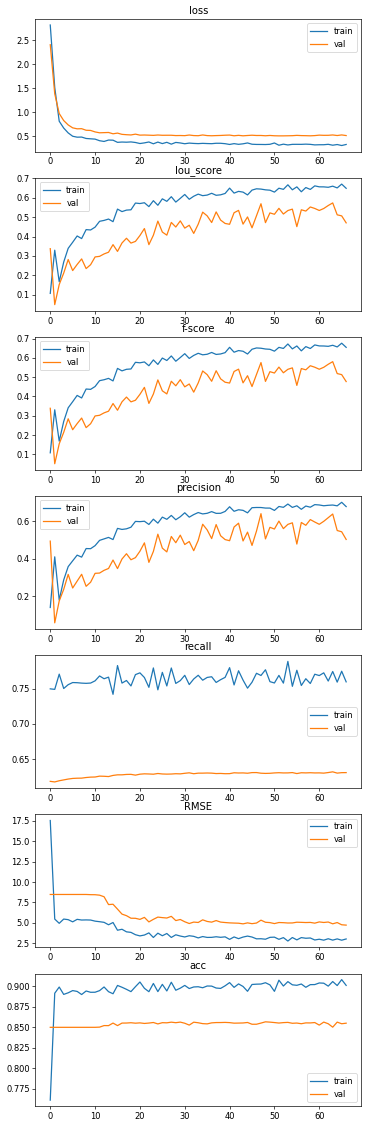

In [7]:
import pandas as pd
loss = history.history["loss"]
val_loss = history.history["val_loss"]
IOU = history.history["_Iou_score"]
val_IOU = history.history["val__Iou_score"]
f_score = history.history["_f_score"]
val_f_score = history.history["val__f_score"]
precision = history.history["metric_precision"]
val_precision = history.history["val_metric_precision"]
recall = history.history["metric_recall"]
val_recall = history.history["val_metric_recall"]
RMSE = history.history["_RMSE"]
val_RMSE = history.history["val__RMSE"]
acc = history.history["acc"]
val_acc = history.history["val_acc"]

epoch = history.epoch #輪次
merge=np.vstack((epoch,loss,val_loss,IOU,val_IOU,f_score,val_f_score,precision,val_precision,
                 recall,val_recall,RMSE,val_RMSE,acc,val_acc))   #沿豎直方向將矩陣堆疊起來
merge=pd.DataFrame(merge)  #轉成df
merge = merge.T  #轉置
merge.columns=['epoch','train_loss','val_loss','train_IOU','val_IOU','train__f_score','val__f_score',
               'train_precision','val_precision','train_recall','val_recall','train_RMSE','val_RMSE',
              'train_acc','val_acc']  #欄位名稱命名
merge.to_csv("./output/model_history_"+t2t+"_"+interval+"_"+choose_model+".csv",index=0) #儲存成csv檔案
"""繪製val&loss曲線"""
import matplotlib.pyplot as plt
plt.figure(12, figsize=(7, 24), dpi=60)
plt.subplot(711)
plt.plot(loss, label='train')
plt.plot(val_loss, label='val')
plt.title('loss')
plt.legend()

plt.subplot(712)
plt.plot(IOU, label='train')
plt.plot(val_IOU, label='val')
plt.title('Iou_score')
plt.legend()

plt.subplot(713)
plt.plot(f_score, label='train')
plt.plot(val_f_score, label='val')
plt.title('f-score')
plt.legend()

plt.subplot(714)
plt.plot(precision, label='train')
plt.plot(val_precision, label='val')
plt.title('precision')
plt.legend()

plt.subplot(715)
plt.plot(recall, label='train')
plt.plot(val_recall, label='val')
plt.title('recall')
plt.legend()

plt.subplot(716)
plt.plot(RMSE, label='train')
plt.plot(val_RMSE, label='val')
plt.title('RMSE')
plt.legend()

plt.subplot(717)
plt.plot(acc, label='train')
plt.plot(val_acc, label='val')
plt.title('acc')
plt.legend()

plt.savefig("./output/model_history_"+t2t+"_"+interval+"_"+choose_model+".png")
plt.show()

## 輸出預測的圖像與二維陣列.csv

In [8]:
"""#predict 【針對單一輪次輸出預測(圖像、陣列)】
#EWB01、EWB10要使用unet.detect_image_merge_label輸出二維陣列到output/predict_array資料夾中
並在計算完輸出CWB18的雨量分布圖做可視化的參考
"""
from utils.model_output import *
from PIL import Image
import glob
import os
import pandas as pd
if not os.path.isdir('./output'):  #若該資料夾不存在則生成資料夾
    os.mkdir('./output')
if not os.path.isdir('./output/predict'):
    os.mkdir('./output/predict')
if not os.path.isdir('./output/predict_array'):
    os.mkdir('./output/predict_array')  
checkpoint = glob.glob('./checkpoint/*.h5')  #glob取出checkpoint所有檔名
for last_checkpoint in checkpoint:  #走訪checkpoint
    None #走完便會將最後一個checkpoint檔名存入llast_checkpoint中
print(last_checkpoint)
#last_checkpoint = './checkpoint/ep075-loss0.624-val_loss1.536.h5' #手動調用想要觀察的模型

if __name__ == '__main__':
    K.clear_session()  #清空權重非常重要
    last_model_weights = False   #是否要調用最後一個模型，True = last；False=best
    blend = False# blend參數用於控制是否讓識別結果和原圖混合  False不混合(輸出純白背景)

    if RD==True and IR==False and RA==False:   #RD
        model_image_size = [128,128,3]
    elif RD==False and IR==False and RA==True:   #RA
        model_image_size = [128,128,3]
    elif RD==False and IR==True and RA==False:  #IR
        model_image_size = [128,128,3]
    elif RD==True and IR==True and RA==False:  #RD+IR
        model_image_size = [128,128,4]
    elif RD==True and IR==False and RA==True:  #RD+RA
        model_image_size = [128,128,6]
    elif RD==False and IR==True and RA==True:  #IR+RA
        model_image_size = [128,128,4]
    elif RD==True and IR==True and RA==True:  #RD+IR+RA
        model_image_size = [128,128,7]
    if GI == True:
        model_image_size[2] = model_image_size[2] +2  #channel+2，GI加在最後一層
    
    model_path = last_checkpoint  #最佳權重
    
    #變數unet 和 函數Unet()僅為代稱，詳情參見model_output.py，內部整合了所有模型的輸出方式
    #將根據choose_model用於選取對應的模型參數
    unet = Unet(model_path=model_path,model_image_size=model_image_size,num_classes=num_classes,
                blend=blend,RD=RD,IR=IR,GI=GI,RA=RA,choose_model=choose_model)
    
    val = pd.read_csv('./database/train_list/'+t2t+'/val.txt',header=None,delimiter=';') #讀取val資料夾用於對應計算
    pre=val[:][0]  #要預測的檔名於第0行中
    for jpg in range(len(pre)):
        RD_image = Image.open("./database/train_data_RD/val/"+pre[jpg])#匯入雷達圖像
        IR_image = Image.open("./database/train_data_IR/val/"+pre[jpg])#匯入IR圖像
        RA_image = Image.open("./database/train_data_RA/"+interval+"/val/"+ pre[jpg]) #匯入雨量分布圖(標籤)
        
        #反正都丟進去，內部在根據RA+RD+IR+GI的組合去判斷要使用哪些資料
        pre_tmp = pre[jpg] #取出第k個標籤，加上t+shift
        pre_tmp = pre_tmp[:-4]+'_t+'+str(shift)  #將標籤的檔名後四位刪除 (刪除.png) 因為標籤為csv形式
        
        #detect_image_merge_label用於輸出預測出來的陣列
        r_label = unet.detect_image_merge_label(RD_image,IR_image,RA_image)
        np.savetxt("./output/predict_array/"+pre_tmp+'.csv', r_label, delimiter=",",fmt='%d',) #預測的值儲存成csv

./checkpoint\Unet3_val_min_RMSE.h5
./checkpoint\Unet3_val_min_RMSE.h5 model loaded.


204.27021276595738
269.074132432676
4.715425674465414
8.474999907996045


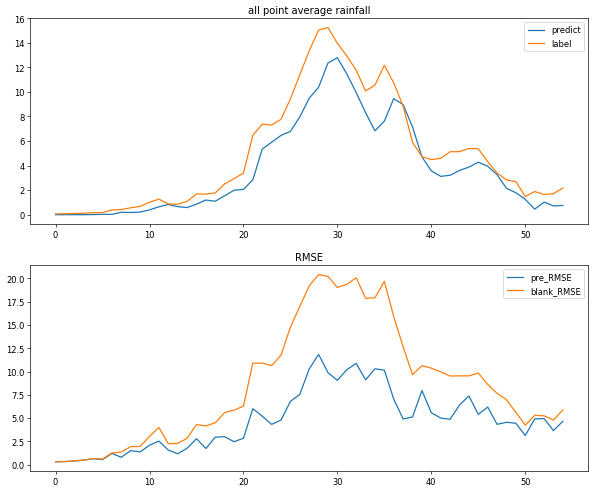

In [9]:
"""
計算【單一輪次的誤差】(標籤轉相對真值與真值相減)，讀取的是predict_array內的資料(陣列)
"""
#----------將標籤映射到CWB的顏色----------#
import matplotlib
nws_precip_colors = [
    "#fdfdfd",  # (253,253,253)   #white 
    "#c1c1c1",  # (193,193,193)  #grays 
    "#99ffff",  # (153,255,255)   #blue 
    "#00ccff",  # (0,204,255)
    "#0099ff",  # (0,153,255)
    "#0166ff",  # (1,102,255)
    "#329900",  # (50,153,0)        #green
    "#33ff00",  # (51,255,0)
    "#ffff00",  # (255,255,0)       #yellow
    "#ffcc00",  # (255,204,0)
    "#fe9900",  # (254,153,0)  
    "#fe0000",  # (254,0,0)          #red
    "#cc0001",  # (204,0,1)
    "#990000",  # (153,0,0)
    "#990099",  # (153,0,153)     #purple
    "#cb00cc",  # (203,0,203)
    "#ff00fe",  # (255,0,254)
    "#feccff"   # (254,204,255)
]
precip_colormap = matplotlib.colors.ListedColormap(nws_precip_colors)
eplison = 1e-7 #將所有標籤加上一個極小值，防止標籤=1的情況判斷成2
#(因為0.1<=x<1；1<=x<2，所以標籤1會歸類成2，也就是灰色變成淺藍色了)
clevels = [0,0.1, 1+eplison, 2+eplison, 6+eplison, 10+eplison, 15+eplison, 20+eplison
           , 30+eplison, 40+eplison, 50+eplison, 70+eplison, 90+eplison,110+eplison
           ,130+eplison,150+eplison, 200+eplison,300+eplison,500+eplison]  #自定義顏色列表
norm = matplotlib.colors.BoundaryNorm(clevels, 18)
CWB18_weight = [0,1,2,4,8,13,18,25,35,45,60,80,100,120,140,175,250,400]
#----------計算累積雨量和RMSE----------#
val = pd.read_csv('./database/train_list/'+t2t+'/val.txt',header=None,delimiter=';') #讀取val資料夾用於對應計算
pre=val[:][0]  #在輸出預測已經將t->t+1的情形考慮進去，輸出了檔名皆對應 
lab=val[:][1]  #標籤的檔名於第1行中
pre_list=[]  
data = np.zeros((len(pre),4), dtype=float)              #建立儲存rmse使用的陣列
for k in range(len(pre)):
    pre_tmp = pre[k] #取出第k個標籤，取出名稱並加上t+shift.png
    pre_tmp = pre_tmp[:-4]+'_t+'+str(shift)+'.csv'  #shift需同predict，參照上格or資料夾
    pre_list.append(pre_tmp) #將預測的名稱存入清單中
    predict = np.genfromtxt('./output/predict_array/'+pre_tmp,delimiter=',') #匯入預測出來的圖像
    #----------將標籤值映射到相對真值----------#
    if interval == 'EWB10':  #如果情況為EWB10則啟用下列計算*5-5 回推相對真值
        predict = predict *10-5  #思路:以10為間隔所以可以直接*10再減去5等於相對真值
        predict[predict <= 0] = 0  #用於將0值變成負號(-5)得情況轉成0
    if interval =='CWB18':
        for i in range(17,-1,-1):  #倒序判斷，從大的標籤往小的去取
            #由小到大會有問題(if 標籤4=>8，因為判斷還會繼續，所以原本4轉8，8就還會再轉成35，造成判斷錯誤
            predict = np.where(predict==i,CWB18_weight[i],predict) #用於將CWB18的標籤值轉為相對真值
    #----------轉換成CWB的圖像化----------#
    plt.figure(figsize=(1,1)) #改變圖片尺寸(英吋)   #1英吋對應dpi pixel 
    plt.imshow(predict,cmap=precip_colormap, alpha=1, norm=norm)  #alpha為透明度
    plt.axis('off')
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)  #控制子圖邊框
    plt.savefig("./output/predict/"+pre_tmp[:-4]+'.png',dpi=128,pad_inches=0.0) 
    plt.close()  #關閉圖像
    
    lab_tmp = lab[k] #取出第k個標籤
    lab_tmp = lab_tmp[:-4]+'.csv'  #將標籤的檔名後四位刪除 (刪除.png) 因為標籤為csv形式
    label = np.genfromtxt('./database/val_label_csv_true_value/'+lab_tmp,delimiter=',') #匯入標籤csv
    label = label[1:,:]  #除去第一列不要的標頭
    average_rmse=0  #(本島)平均均方根誤差
    blank_rmse=0      #計算標籤和全白的預測的誤差(=label-0)  (搞不好全白的預測還比我們的好XD)
    sum_pre=0 #本島預測累積雨量
    sum_lab=0 #本島真實累積雨量
    bias=predict-label        #絕對誤差
    
    sum_pre  = np.sum(predict)  #上方加總功能若是不管外邊，單純標籤相加減計算
    sum_lab  = np.sum(label)
    average_rmse = np.sum(bias**2)
    blank_rmse = np.sum(label**2)
    average_rmse = (average_rmse/4700)**0.5  #台灣本島內共有4700格
    blank_rmse = (blank_rmse/4700)**0.5          
    #print(average_rmse)   #標籤與預測圖像的誤差 (全島加總)
    #print(blank_rmse)       #標籤與全白圖像的誤差  
    #blank_rmse的意義為如果預測為全白的圖像，他的誤差會是多少?如果預測結果比這個還差是不是有問題
    
    data[k,0]=sum_pre/4700  #雨量加總除以4700代表臺灣本島平均降雨量
    data[k,1]=sum_lab/4700
    data[k,2]=average_rmse
    data[k,3]=blank_rmse

#----------輸出平均降雨量&RMSE----------#
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(12, figsize=(12, 10), dpi=60)
plt.subplot(211)
plt.plot(data[:,0], label='predict')
plt.plot(data[:,1], label='label')
plt.title('all point average rainfall')
plt.legend()

plt.subplot(212)
plt.plot(data[:,2], label='pre_RMSE')
plt.plot(data[:,3], label='blank_RMSE')
plt.title('RMSE')
plt.legend()
pre_sum = sum(data[:,0])
label_sum = sum(data[:,1])
pre_rmse = sum(data[:,2])/len(pre)
blank_rmse = sum(data[:,3])/len(pre)
print(pre_sum) #全台平均降雨量(預測)
print(label_sum) #全台平均降雨量(真實)
print(pre_rmse) #全台平均rmse(預測)
print(blank_rmse) #全台平均rmse(真實-空白)
header=['pre_sum','label_sum','pre_rmse','blank_rmse','time']
df=pd.DataFrame(data)
df.insert(df.shape[1],'time' , pre_list)
df.to_csv('./output/model_pre_sum_rmse-'+str(round(pre_rmse,4))+'_'+t2t+'_'+interval+'_'+choose_model+'.csv', index=True, header=header, sep=',')
plt.savefig('./output/model_pre_sum_rmse-'+str(round(pre_rmse,4))+'_'+t2t+'_'+interval+'_'+choose_model+'.png')